<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Time Series: Forecasting Models

<h2><a id="A">Time Series Models</a></h2>

**Time series forecasting** is the use of a model to predict future values based on previously observed values. We will discuss these types of models in this section. 

- Time series forecasting models predict a future value in a time series. Like other predictive models, we will use prior history to predict the future. Unlike previous models, however, we will use the _outcome_ variables from earlier in time as the _inputs_ for prediction.


- As with the modeling you're used to, we will have to evaluate different models to ensure that we have chosen the best one.


- So, we will want to evaluate on _test data_ to ensure that our model performs well on unseen data.


**Time series analysis** comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. (The analyses we've been doing in previous section qualify as time series analysis).




### What Makes Time Series Data Special?

Time series data are time dependent. So, the basic assumption of a linear regression model — that the observations are independent — falls apart. Often, time series data include some sort of trend or may have seasonality.

<h2><a id = "B">Properties of Time Series Forecasting Models</a></h2>

### Training and Testing Sets

Time series data have a natural temporal ordering, which makes them different from the studies we've seen in other lessons in which there was no natural ordering of observations. 

Because these data are ordered, we **cannot choose training and testing examples at random.** As we are attempting to predict _a sequence of future values_, we must train on values from earlier (in time) in our data and then test our values at the end of the period.

### Moving Averages and Autocorrelation

In previous sections, we learned about a few statistics for analyzing time series. A **moving average** is the average of *k* surrounding data points in time.

We also looked at autocorrelation the compute the relationship of the data with prior values.

**Autocorrelation** is how correlated a variable is with itself. Specifically, how related variables from earlier in time are with variables from later in time. Note the need for a mean value:

${\Huge R(k) = \frac{\operatorname{E}[(X_{t} - \mu)(X_{t-k} - \mu)]}{\sigma^2}}^*$

### Testing for Stationarity

Import the libraries and data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")
drones = pd.read_csv('assets/data/gt_drone_racing.csv', header=1)
drones.columns = ['week','drone_racing_interest']
drones.head()

,week,drone_racing_interest
0,2014-11-09,2
1,2014-11-16,2
2,2014-11-23,4
3,2014-11-30,6
4,2014-12-07,7


Change the `week` column to a `datetime` object and make it the index of the DataFrame.

In [2]:
drones['week'] = pd.to_datetime(drones.week)
drones.set_index('week', inplace=True)
drones.head()

,drone_racing_interest
week,
2014-11-09,2
2014-11-16,2
2014-11-23,4
2014-11-30,6
2014-12-07,7


Plot the data.

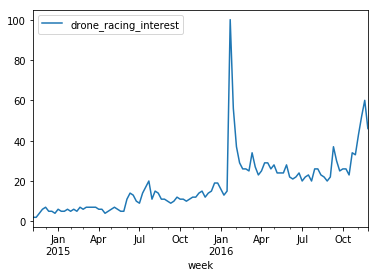

In [3]:
drones.plot()

It's clear that there is an overall increasing trend, as well as some seasonal variations. 

But, if this visual check for stationarity wasn't so clear, we could use the following:


* **Plotting rolling statistics**: This is another visual technique, but it can help us see if the moving average or moving variance varies over time. 





* **Dickey-Fuller test**: This is a statistical test for checking for stationarity. The null hypothesis of this test is that the time series is non-stationary. The Dickey-Fuller test returns a test statistic that is compared to a critical value for different confidence levels. If the test statistic is less than the critical value, we reject the null hypothesis and say that the time series is stationary.  

Here's a function for plotting rolling statistics and using the Dickey-Fuller test. We'll use it on our drone data. 

In [4]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    # Determining rolling statistics:
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    # Plotting rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Performing the Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

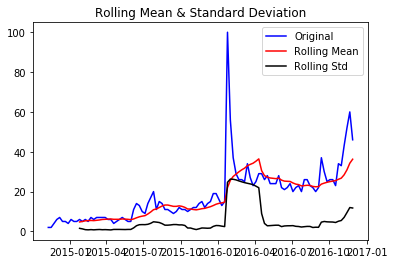

Results of Dickey-Fuller Test:
Test Statistic                  -3.811995
p-value                          0.002787
#Lags Used                       0.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


In [5]:
test_stationarity(drones.drone_racing_interest)

Although the variation in the standard deviation experiences one jump, the mean is clearly increasing with time. So, this is not a stationary series. Also, the test statistic of the Dickey-Fuller test is way more than the critical values. (Compare the signed values, not the absolute values.)

Let's discuss methods for making this time series stationary.

### Making a Time Series Stationary

To make a time series stationary, we first need to understand what makes a it non-stationary. Two things can do this:



1) **Trend**: Variation over time. <br>

2) **Seasonality**: Variations at specific timeframes. <br>

### Detrending

We can preprocess our data to achieve stationarity. Two common methods are **detrending** and **differencing**.



**Detrending** removes major trends in our data. The simplest way is to fit a line to the trend, then make a new series of the difference between the line and the true series. 



Below are U.S. housing prices over time that demonstrate an upward trend. This makes the time series non-stationary, as the mean home price is increasing. The line fit through it represents the trend.

The bottom figure is the "detrended" data, where each data point is transformed by subtracting the value of the trend line at that point. This data now have a fixed mean and may be easier to model. This is similar to mean-scaling our features in earlier models with `StandardScaler`.

![](assets/images/detrend.gif)

#### Example: Detrending

Fit a trendline to the data.

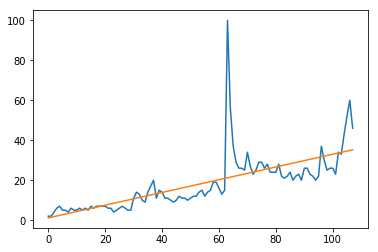

In [6]:
import numpy as np
import matplotlib.pyplot as plt
drones = pd.read_csv('assets/data/gt_drone_racing.csv', header=1)
drones.columns = ['week','drone_racing_interest']
coefs = np.polyfit(drones.index, drones.drone_racing_interest,1)
lineFunction = np.poly1d(coefs)
plt.plot(drones.index, drones.drone_racing_interest, drones.index, lineFunction(drones.index))

Detrend the time series. In its simplest form, we literally subtract the trendline from the time series.

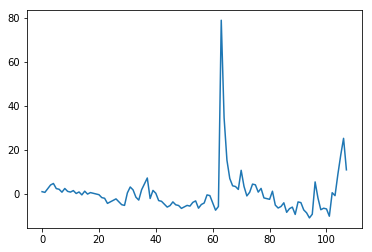

In [7]:
plt.plot(drones.index, drones.drone_racing_interest - lineFunction(drones.index));

### Differencing

A related method is **differencing**. Instead of predicting the (non-stationary) series, we can predict the difference between two consecutive values. **ARIMA** models incorporate this approach.

Recall that we used Pandas' `.diff()` method to find the difference in an earlier section.

#### Example: Differencing

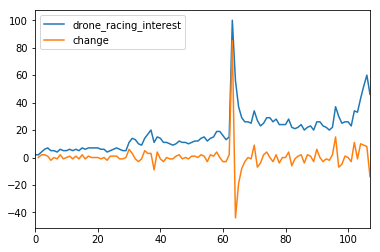

In [8]:
drones['change'] = drones.drone_racing_interest.diff(1);
drones.plot()

<h2><a id="C">Time Series Forecasting Methods</a></h2>

###  ARIMA

A very popular forecasting method is **ARIMA**, which stands for **autoregressive integrated moving average.** 

Extension of Autoregressive (AR) and Moving Average (MA) models.


"Auto-regressive": "values depend on past values"

"Integrated": "time series is not stationary and needs differencing"

"Moving average": "use previous errors as they are also informative"

With ARIMA, we train a model to predict the difference of the series (as opposed to the value of the series)


- ${y_{t} - y_{t-1} = {ARIMA(p,q)}}$


This handles the stationarity assumption we wanted for our data.  Instead of detrending or differencing manually, the model does this.


You need to choose some parameters:

`p`: how much lag in the auto-regressive term? (how far back should I go?) (AR)

`d`: differencing term (how much differencing to make it stationary?) (I)

`q`: how much lag to add to the error terms (MA)

ARIMA is just a family of models, with many extensions

- "SARIMA": seasonal ARIMA: can handle seanonality

- "ARIMAX": ARIMA with the ability to add additional features

- "SARIMAX": combination of the two

Let's look at another dataset, this time of average number of bus riders in Portland, Oregon.

In [9]:
bus = pd.read_csv("assets/data/bus.csv", names=["month", "avg_riders"])
bus.head()

,month,avg_riders
0,1960-01,648
1,1960-02,646
2,1960-03,639
3,1960-04,654
4,1960-05,630


In [10]:
bus["date"] = pd.to_datetime(bus["month"], format="%Y-%m")

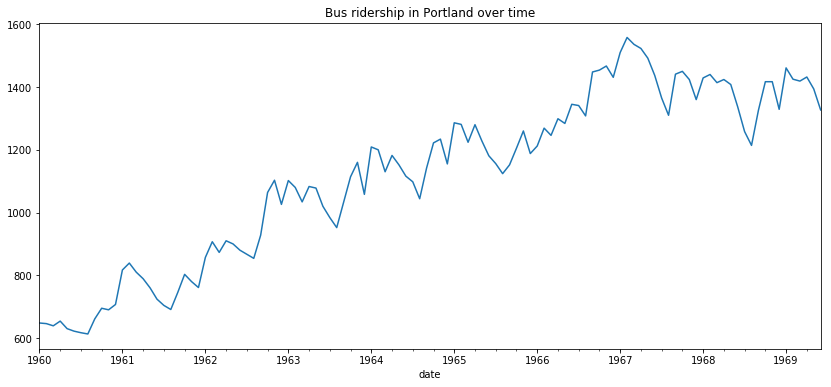

In [11]:
riders = bus.set_index("date")["avg_riders"]
riders.plot(figsize=(14, 6), title="Bus ridership in Portland over time");

In [12]:
train = riders["1960":"1965"] # 6 years
test = riders["1966":"1968"] # 3 years

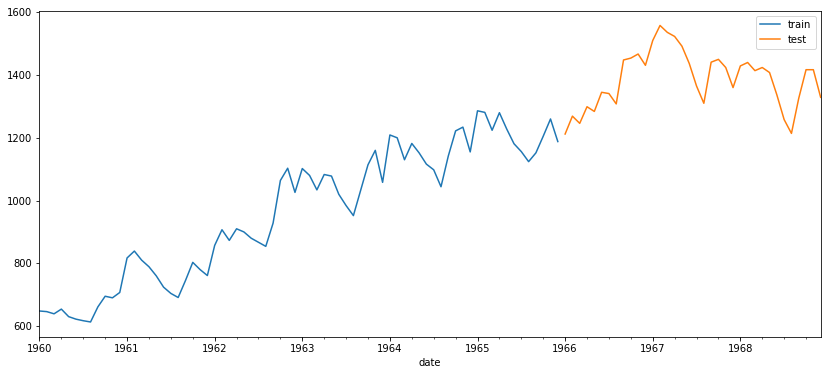

In [13]:
fig, ax = plt.subplots(figsize=(14, 6))

train.plot(ax=ax, label="train")
test.plot(ax=ax, label="test")
ax.legend()

plt.show()

In [14]:
import statsmodels.api as sm

model = sm.tsa.SARIMAX(train, order=(2, 1, 0), seasonal_order=(1, 1, 0, 12)).fit()
y_pred = model.predict(start="1966-01-01", end="1968-12-01")

/Users/ohalloranb/anaconda/envs/python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


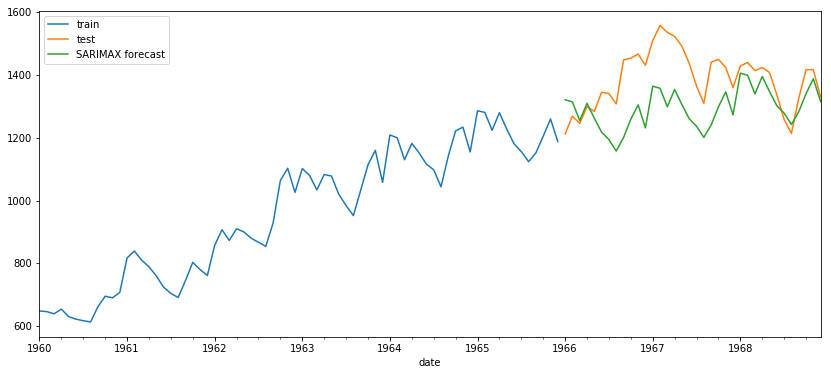

In [15]:
fig, ax = plt.subplots(figsize=(14, 6))

train.plot(ax=ax, label="train")
test.plot(ax=ax, label="test")
y_pred.plot(ax=ax, label="SARIMAX forecast")
ax.legend()

plt.show()

## Closing thoughts / What next?

- ARIMA models require tuning those parameters (further reading in README.md)

- you can understand a lot about time series from simple plots (by day, by month etc.)

- time series forecasting is **hard**

- traditional approaches to time series are more mature than "machine learning for time series"

_"The forecasting accuracy of ML forecasting methods is lower than the worst of statistical ones while the accuracy of more than half the ML methods is lower than a random walk"_

![](assets/images/ml_vs_time_series.jpg)

<small>Source: <a href="https://twitter.com/MScDigital/status/984725381394690048">https://twitter.com/MScDigital/status/984725381394690048</a></small>